In [117]:
import os
import json
import sqlite3
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [118]:
all_events = []
for root,directories, files in os.walk('../nni'):
    for file in files:
        file_name = '{}/{}'.format(root,file)
        meta_data = file_name.split('/')
        experiment_id = meta_data[3]
        if 'log' in file_name or 'run.sh' in file_name or 'stderr' in file_name:
            continue
        if 'sqlite' in file_name:
                try:
                    conn = sqlite3.connect(file_name)
                    c = conn.cursor()
                    c.execute('SELECT * FROM TrialJobEvent')
                    result = c.fetchall()
                    all_events+=[{'time_point':  datetime.datetime.fromtimestamp(i[0]/1000),
                                  'experiment_id': experiment_id,
                                  'trial_id': i[1],
                                  'type': i[2],
                                  'queue': json.loads(i[3])['parameter_id'] if i[3] else None,
                                  'batch': json.loads(i[3])['parameters']['batch'] if i[3] else None,
                                  'hidden_factors': json.loads(i[3])['parameters']['hidden_factors'] if i[3] else None,
                                  'regularizer': json.loads(i[3])['parameters']['regularizer'] if i[3] else None,
                                 } for i in result] 
                finally:
                    conn.close()

In [119]:
all_events_df = pd.DataFrame(all_events)
all_events_df['duration'] = 0

In [120]:
for trial_id, body in all_events_df.groupby('trial_id'):
    begin_time = body[body['type']=='RUNNING']['time_point'].array
    end_time = body[body['type']=='SUCCEEDED']['time_point'].array
    if end_time.size == 0:
        all_events_df = all_events_df[all_events_df['trial_id']!=trial_id]
    else:
        all_events_df.loc[all_events_df['trial_id']==trial_id, 'duration'] = (end_time[0] - begin_time[0]).total_seconds()

/home/hugh/PycharmProjects/nni-experiments/venv/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [121]:
all_events_df = all_events_df[all_events_df['type']=='WAITING'].drop(columns=['type'])
all_events_df['value'] = 0

In [122]:
with open('experiment_model1.json', 'r') as f:
    data_json = json.loads(f.read())

In [123]:
for k, v in data_json.items():
    for trial in v['trials']:
        if 'trial_job_id' not in trial:
            continue
        all_events_df.loc[all_events_df['trial_id']==trial['trial_job_id'], 'value'] = float(trial['value'])
        all_events_df.loc[all_events_df['trial_id']==trial['trial_job_id'], 'method'] = v['method']

In [124]:
duration_df = pd.DataFrame([{'method': method,
  'duration':sum(data['duration'])
 } for method, data in all_events_df.groupby('method')])

In [125]:
print([i for i in all_events_df['method'].unique()])
print([i for i in all_events_df.columns])

['BOHB', 'GridSearch', 'Evolution', 'GPTuner', 'TPE', 'Random', 'MetisTuner', 'Hyperband', 'SMAC', 'PBTTuner', 'Anneal', 'BatchTuner']
['time_point', 'experiment_id', 'trial_id', 'queue', 'batch', 'hidden_factors', 'regularizer', 'duration', 'value', 'method']


In [126]:
all_events_df[all_events_df['method']=='GridSearch']

,time_point,experiment_id,trial_id,queue,batch,hidden_factors,regularizer,duration,value,method
89,2020-06-30 15:16:20.038,uvckVe1K,XPKXM,0,128.0,4.0,-8.0,463.246,0.721625,GridSearch
92,2020-06-30 15:24:15.887,uvckVe1K,OqtDQ,1,128.0,4.0,-7.5,465.144,0.718150,GridSearch
95,2020-06-30 15:32:11.797,uvckVe1K,S0nUc,2,128.0,4.0,-7.0,455.096,0.717425,GridSearch
98,2020-06-30 15:39:57.697,uvckVe1K,LU5cM,3,128.0,4.0,-6.5,451.662,0.712500,GridSearch
101,2020-06-30 15:47:38.577,uvckVe1K,BZeVO,4,128.0,4.0,-6.0,458.888,0.715900,GridSearch
104,2020-06-30 15:55:29.517,uvckVe1K,RXxRw,5,128.0,4.0,-5.5,460.881,0.714875,GridSearch
107,2020-06-30 16:03:20.445,uvckVe1K,D0HPo,6,128.0,4.0,-5.0,457.251,0.719325,GridSearch
110,2020-06-30 16:11:06.353,uvckVe1K,au9Ec,7,128.0,4.0,-4.5,461.227,0.711900,GridSearch
113,2020-06-30 16:18:57.281,uvckVe1K,HKFpn,8,128.0,4.0,-4.0,465.185,0.708175,GridSearch
116,2020-06-30 16:26:53.269,uvckVe1K,c1pFt,9,256.0,4.0,-8.0,252.107,0.672700,GridSearch


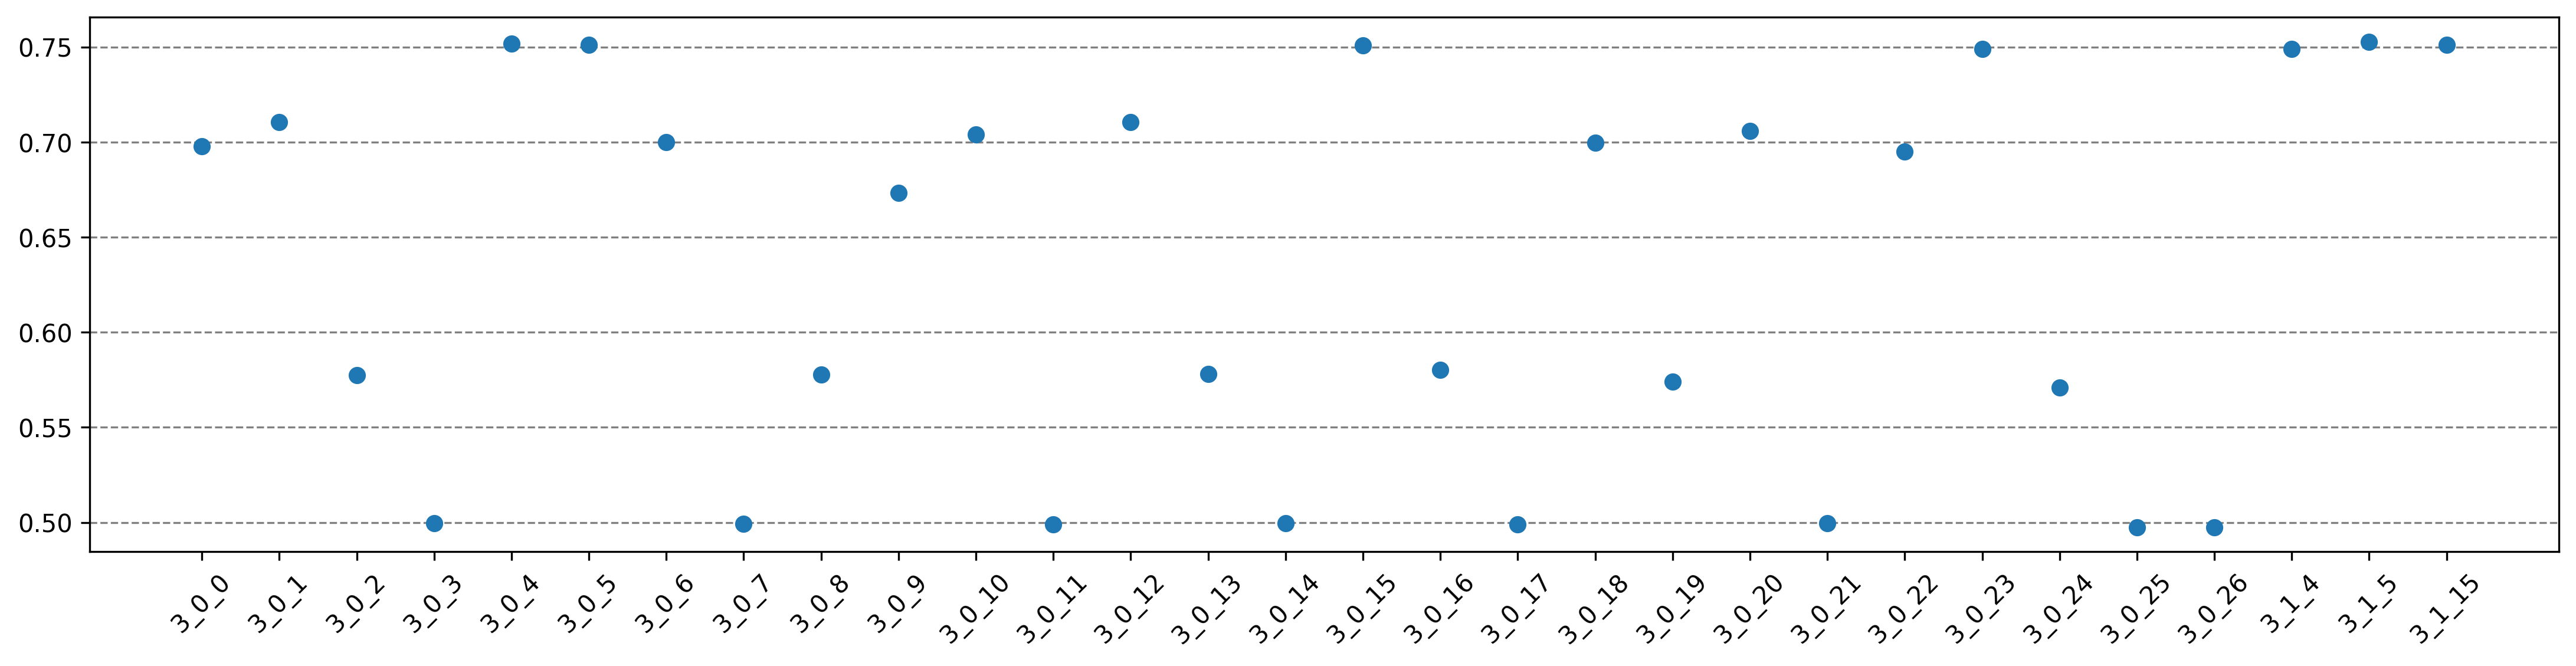

In [127]:
single_method = all_events_df[all_events_df['method']=='Hyperband']
single_method = single_method.set_index('queue')
fig, ax = plt.subplots(figsize=(18,4), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.scatter(single_method.index,single_method['value'])
plt.xticks(single_method.index, rotation=45)
plt.show()

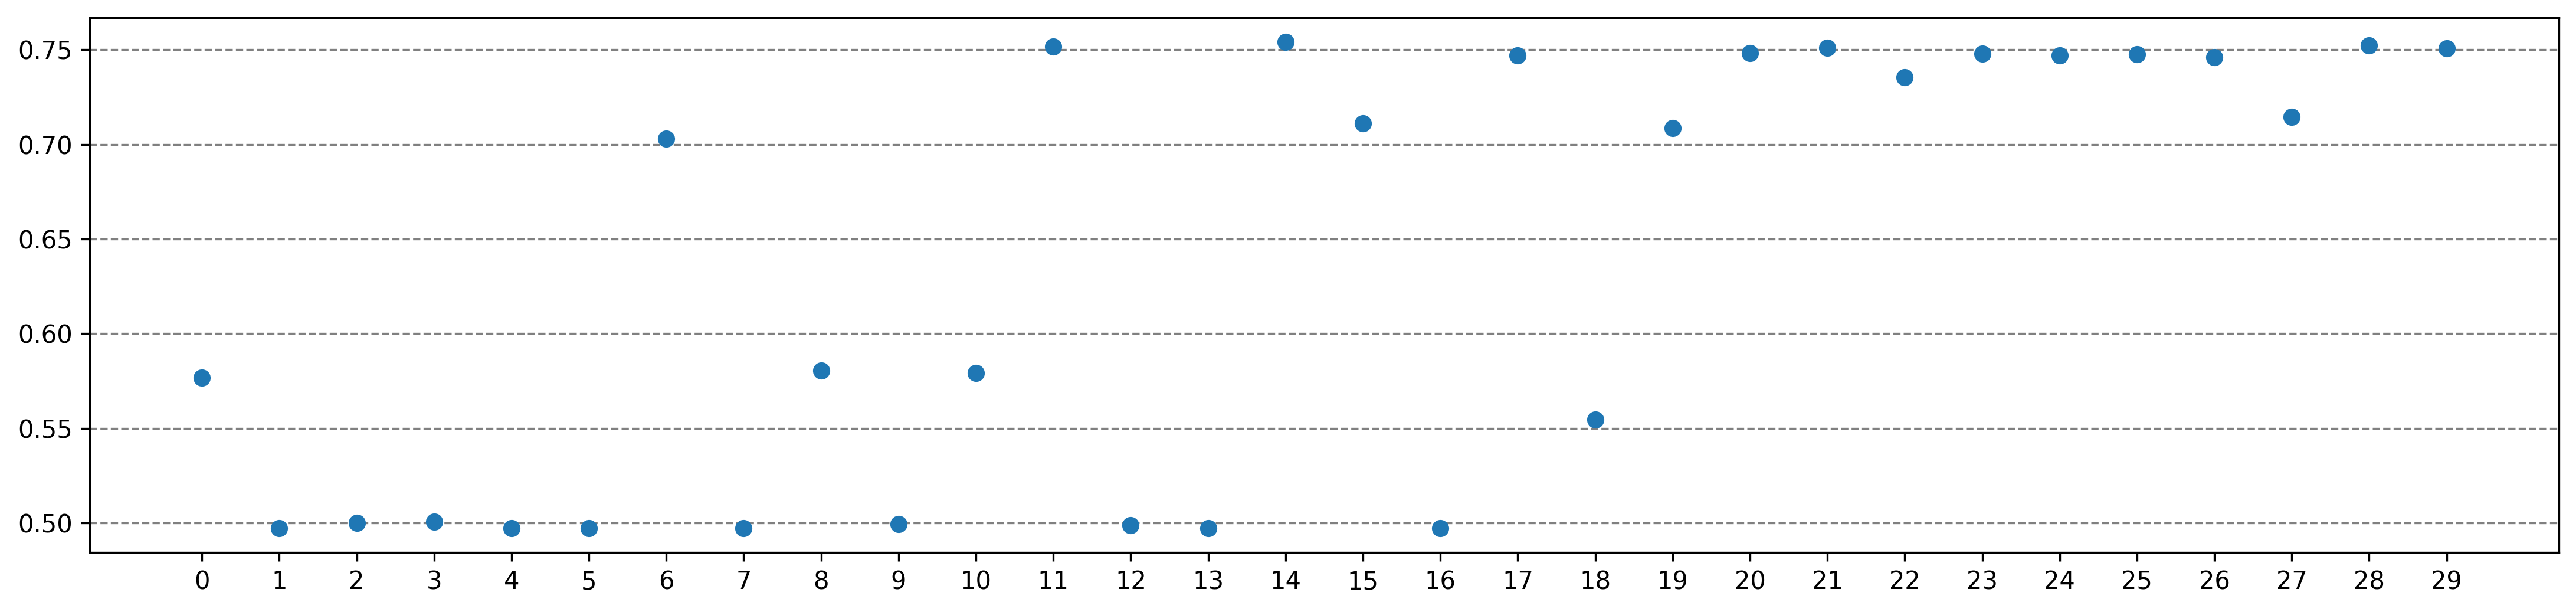

In [128]:
single_method = all_events_df[all_events_df['method']=='TPE']
single_method = single_method.set_index('queue')
fig, ax = plt.subplots(figsize=(18,4), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.scatter(single_method.index,single_method['value'])
plt.xticks(single_method.index)
plt.show()

In [129]:
summary_data = all_events_df[['batch','hidden_factors','regularizer','duration', 'value']].sort_values('value', ascending=False)
batch_data = [[k,v['value'].max(), v['value'].min(), v['duration'].max(), v['duration'].min()] for k, v in summary_data.groupby('batch')]
batch_data = np.array(batch_data)

In [130]:
batch_data[:,2]

array([0.69999999, 0.65682501, 0.54812503, 0.49847499, 0.49722499])

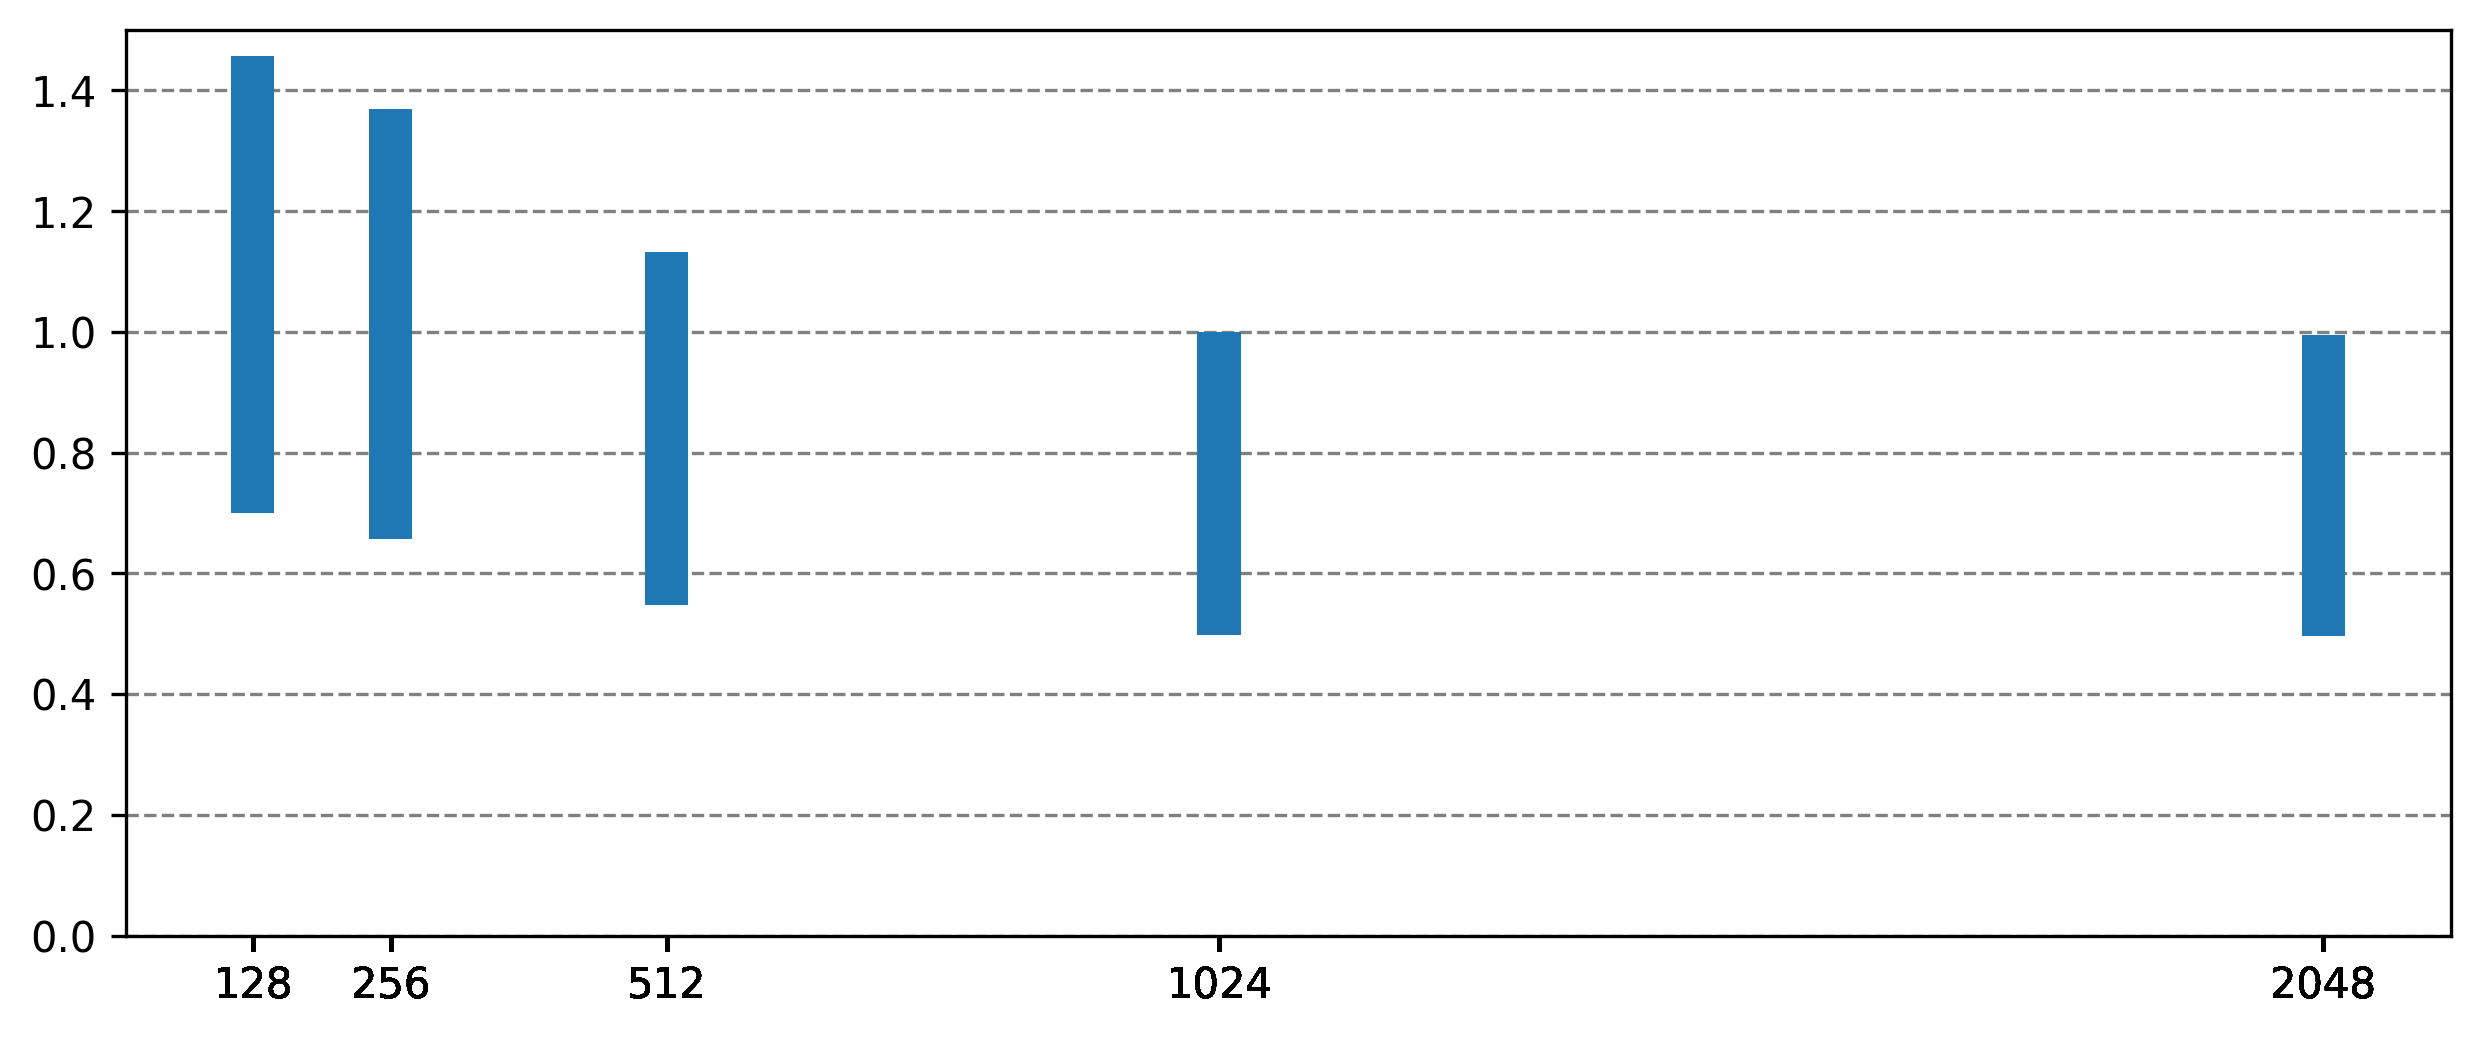

In [131]:
fig, ax = plt.subplots(figsize=(10,4), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.ylim(0,1.5)
plt.bar(batch_data[:,0],batch_data[:,1],bottom=batch_data[:,2], width=40)
plt.xticks(summary_data['batch'])
plt.show()

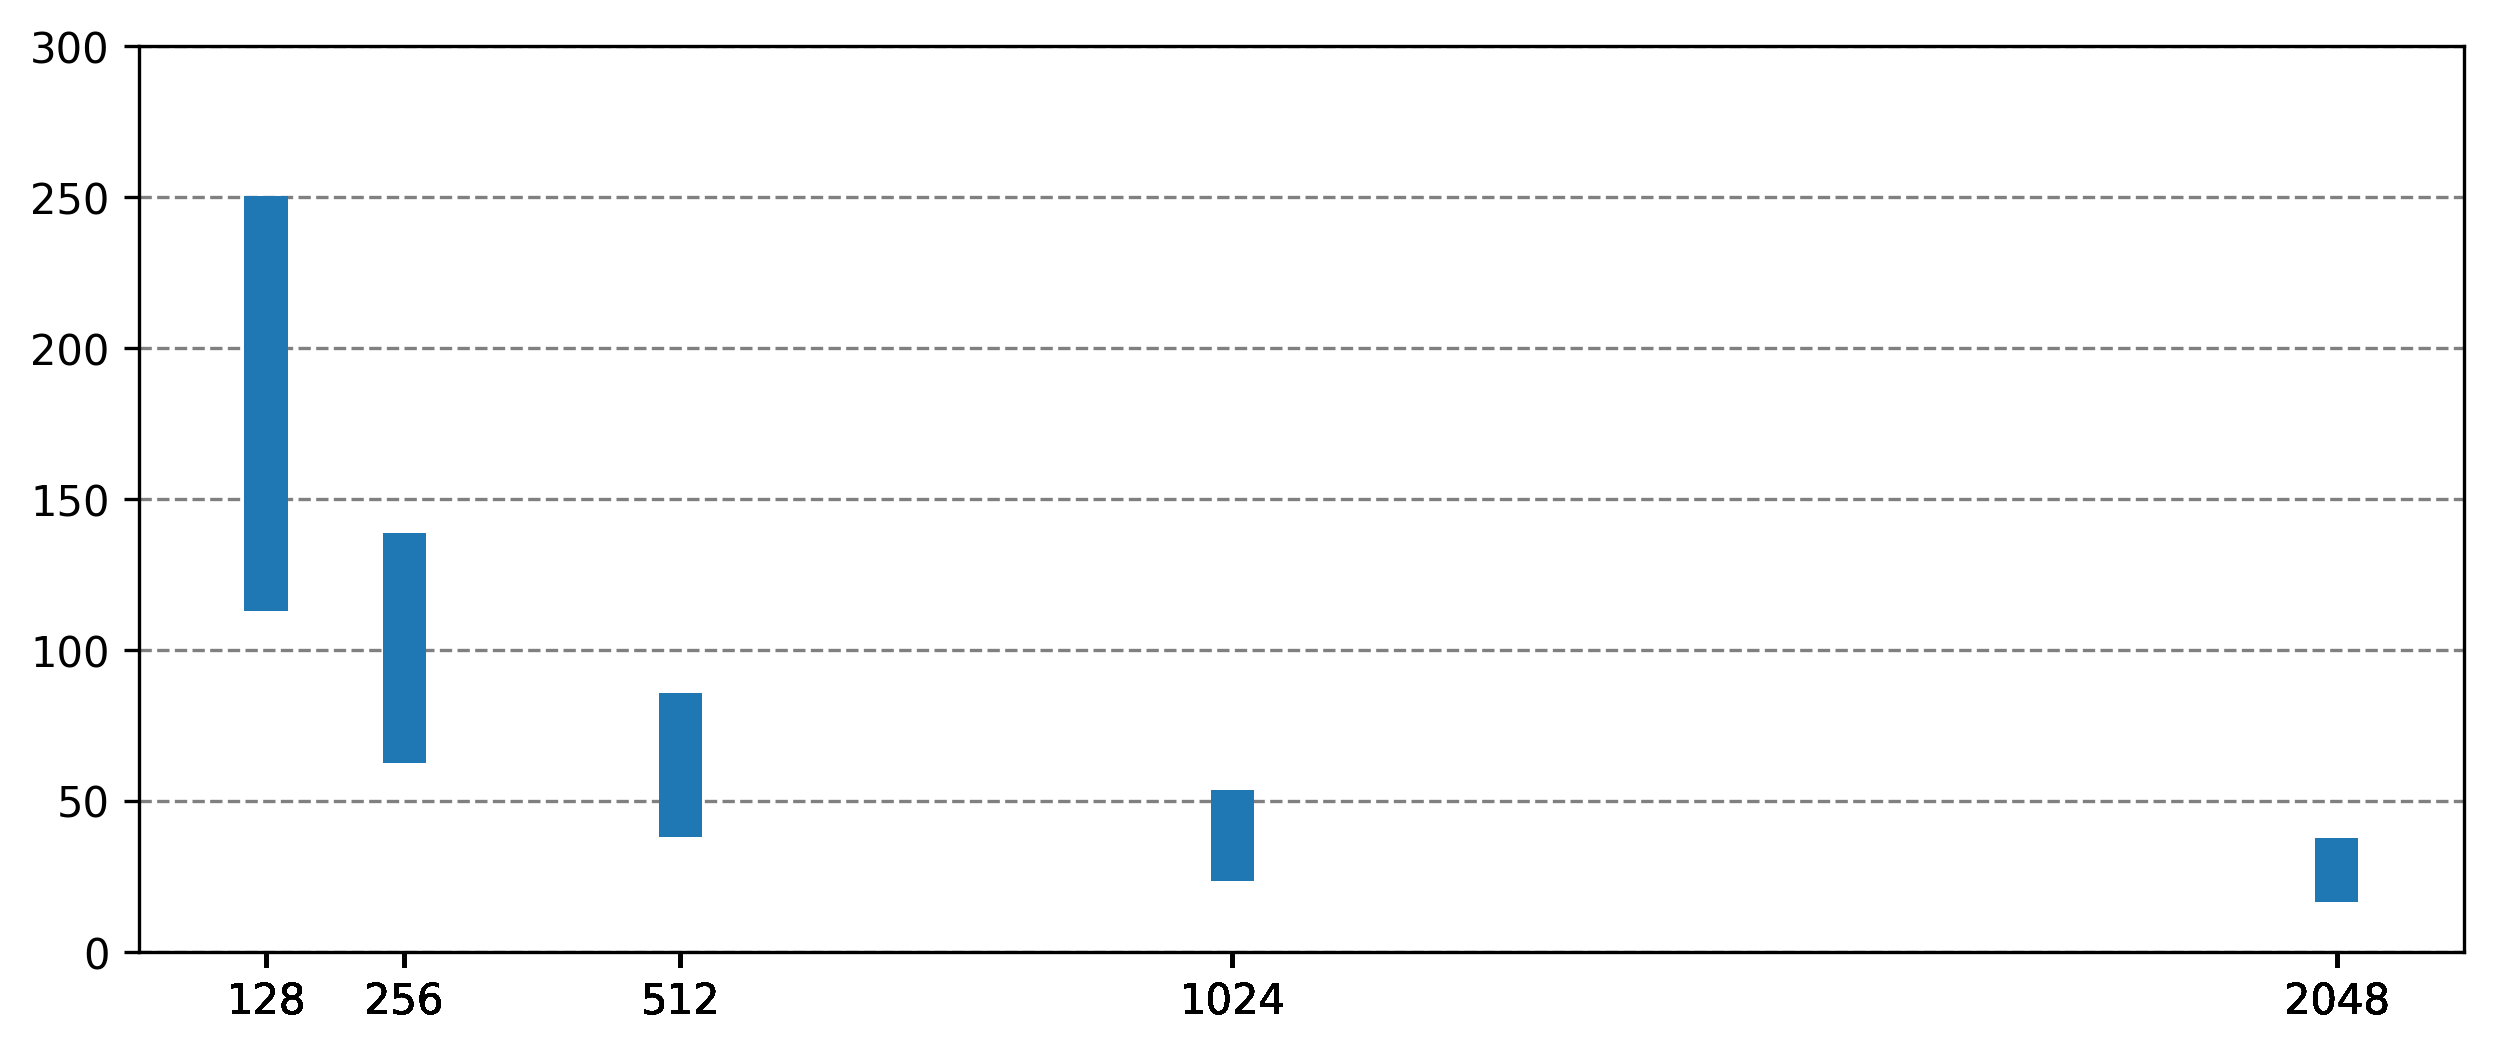

In [132]:
fig, ax = plt.subplots(figsize=(10,4), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.ylim(0,300)
plt.bar(batch_data[:,0],batch_data[:,3]/4,bottom=batch_data[:,4]/4, width=40)
plt.xticks(summary_data['batch'])
plt.show()

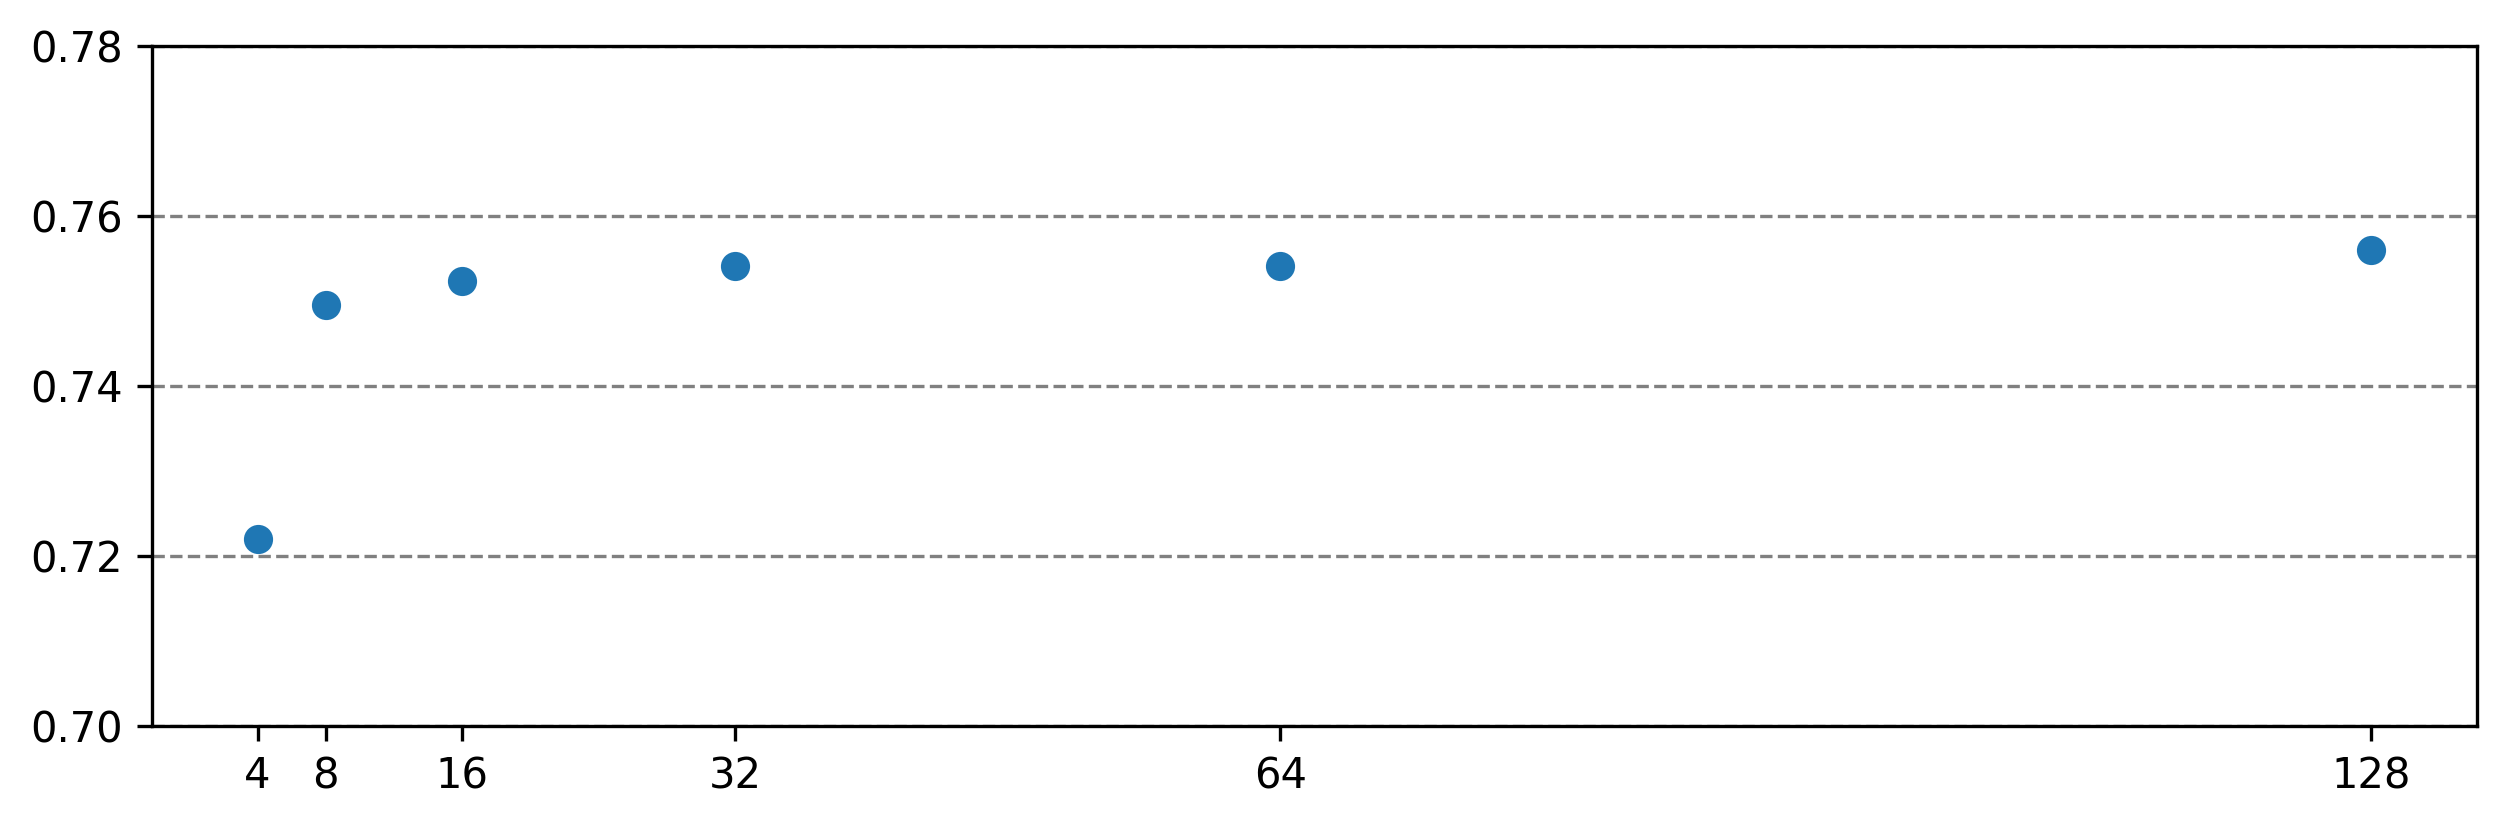

In [149]:
factor_data = [[k,v['value'].max(), v['value'].min(), v['duration'].max(), v['duration'].min()] for k, v in summary_data.groupby('hidden_factors')]
factor_data = np.array(factor_data)
fig, ax = plt.subplots(figsize=(10,3), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.ylim(0.7,0.78)
plt.scatter(factor_data[:,0],factor_data[:,1])
plt.xticks(factor_data[:,0])
plt.show()

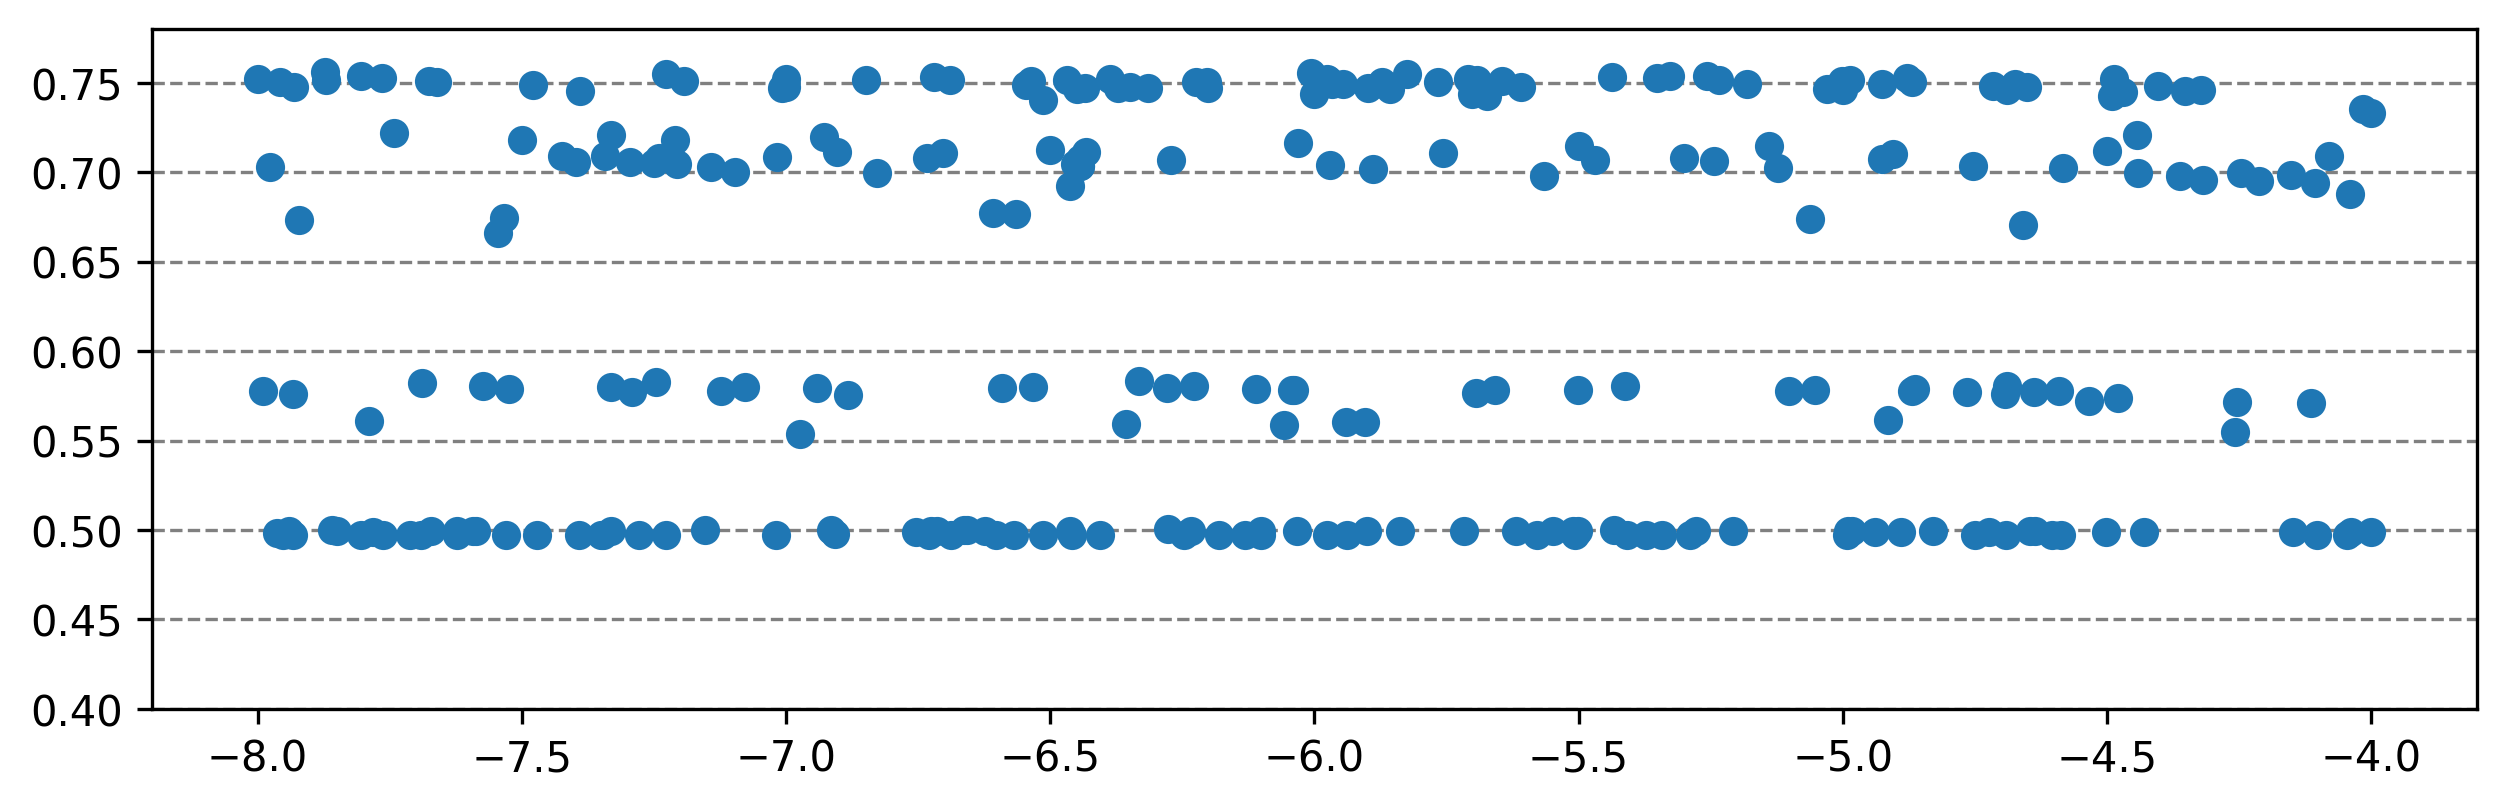

In [154]:
regularizer_data = [[k,v['value'].max(), v['value'].min(), v['duration'].max(), v['duration'].min()] for k, v in summary_data.groupby('regularizer')]
regularizer_data = np.array(regularizer_data)
fig, ax = plt.subplots(figsize=(10,3), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.ylim(0.4,0.78)
plt.scatter(regularizer_data[:,0],regularizer_data[:,1])
plt.show()

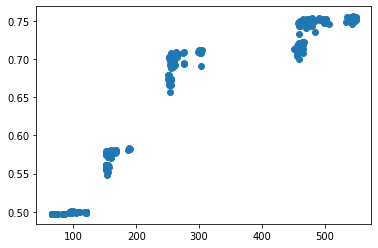

In [148]:
plt.scatter(summary_data['duration'],summary_data['value'].values)